In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/calc_value_growth_history.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Fees'):
        fnames['Fees'] = fname                
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-07-31.csv',
 'AUM & Glp Supply': 'AUM & Glp Supply_2021-08-31_2022-07-31.csv',
 'Fees': 'Fees_2021-08-31_2022-07-31.csv'}

## Prep Data

In [7]:
# read GLP price data
glp_prices = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                         index_col='Date', parse_dates=['Date'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .loc[:, ['glpPrice', 'glpPlusFees']]
                .rename(columns={'glpPrice':'glp_price', 'glpPlusFees':'glp_plusfees_price'})
             )
glp_prices.tail()

,glp_price,glp_plusfees_price
Date,,
2022-07-25,0.8796,1.1936
2022-07-26,0.8839,1.1985
2022-07-27,0.9377,1.2528
2022-07-28,0.9645,1.2806
2022-07-29,0.9642,1.2829


In [8]:
# read glp supply data
glp_supply = (pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                           parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
                .iloc[:-1, ] # drop the last row since it may not be a full day
                .rename(columns={'glpSupply':'glp_supply'})
                .squeeze()
              )
glp_supply.tail()

Date
2022-07-26   207,971,518.1852
2022-07-27   209,132,510.3007
2022-07-28   209,063,452.4263
2022-07-29   213,222,478.2006
2022-07-30   214,302,358.9253
Name: glp_supply, dtype: float64

In [9]:
# # calculate daily GLP pool dollar value
# glp_pool_value = glp_prices['glp_price'] * glp_supply
# glp_pool_value.name = 'glp_pool_value'
# glp_pool_value

In [10]:
# read fees data
fees = (pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                    parse_dates=['Date'], index_col='Date', 
                    # ignore the last col "Cumulative" cuz it's NOT the daily total, but cumulative daily total 
                    usecols=range(6))
          .iloc[:-1, ] # drop the last row since it may not be a full day
       )
fees.columns = fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
fees['total_fees'] = fees.sum(axis=1)
fees.tail()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2022-07-26,"16,573.4486","145,438.1785","4,319.6909","4,680.5812",409.0583,"171,420.9575"
2022-07-27,"30,408.3547","109,175.6009","2,042.5030","1,897.9739","1,061.3064","144,585.7390"
2022-07-28,"25,571.5730","257,373.8200","4,695.7405","13,807.3735","2,108.3545","303,556.8614"
2022-07-29,"24,188.8972","770,647.8275","5,527.6549","3,214.9813",641.5721,"804,220.9330"
2022-07-30,"13,382.6502","155,126.3749","1,903.6862","1,268.5221","1,267.5886","172,948.8220"


In [11]:
# how much fees (in dollars) does 1 GLP earn? Think of it as daily dividend
# 1% goes to keepers, and 70% of the rest goes to GLP holders
fees_per_share = fees['total_fees'] * (1-0.01) * 0.7 / glp_supply
fees_per_share.name = 'fees_per_share'
fees_per_share

Date
2021-08-31   0.0001
2021-09-01   0.0041
2021-09-02   0.0014
2021-09-03   0.0019
2021-09-04   0.0004
              ...  
2022-07-26   0.0006
2022-07-27   0.0005
2022-07-28   0.0010
2022-07-29   0.0026
2022-07-30   0.0006
Name: fees_per_share, Length: 334, dtype: float64

## Set up 

allow users to enter their own numbers and see output

In [12]:
# user input
start_date = glp_prices.index[0]     # investment start date, can use a date string, for example, '2022-06-15'
init_capital = 10_000                # dollars

In [13]:
# what's my purchase price?
init_price = glp_prices.loc[start_date, 'glp_price'] # use the avg daily price on start date 
# how much GLP did I buy?
init_shares = init_capital / init_price
print('Purchase price: ${:.3f}'.format(init_price), 'Shares: {:.4f}'.format(init_shares))

Purchase price: $1.194 Shares: 8378.4168


In [14]:
res = dict() # hold output growth paths

## Reinvest Rewards

In [15]:
# manually reinvest fees daily
daily_shares = [init_shares]
subdf_prices = glp_prices.loc[start_date:]

for i in range(len(subdf_prices)-1):
    shares_today = daily_shares[-1] # assume we buy shares at day end so we don't earn any fees today
    # our shares start earning fees tomorrow. This is to match with the data which gives the same
    # glp_price and glp_plusfees_price at inception.
    fees_earned_tomorrow = fees_per_share[i+1] * shares_today
    price_tomorrow = subdf_prices.glp_price[i+1]
    daily_shares.append(shares_today + fees_earned_tomorrow / price_tomorrow)
daily_shares = pd.Series(daily_shares)

# calc daily values
value_growth_daily_compounded = daily_shares * subdf_prices.glp_price.values
value_growth_daily_compounded.index = subdf_prices.index
value_growth_daily_compounded

Date
2021-08-31   10,000.0000
2021-09-01   10,870.7666
2021-09-02   10,840.0901
2021-09-03   11,007.4978
2021-09-04   11,023.4352
                 ...    
2022-07-25   10,012.8100
2022-07-26   10,068.1735
2022-07-27   10,687.0040
2022-07-28   11,003.3124
2022-07-29   11,030.2332
Length: 333, dtype: float64

In [16]:
name = 'Reinvest {} rewards daily'.format(reward_token)
res[name] = value_growth_daily_compounded

## Sell rewards into USD instead of reinvesting into GLP

In [17]:
# calc investment value due to GLP price movement
value_growth_price_driven = calc_value_growth_history(glp_prices.glp_price, start_date, init_capital)
value_growth_price_driven

Investment started on 2021-08-31 00:00:00 



2021-08-31   10,000.0000
2021-09-01   10,836.1130
2021-09-02   10,793.5653
2021-09-03   10,944.0314
2021-09-04   10,956.1517
                 ...    
2022-07-25    7,369.5198
2022-07-26    7,405.4821
2022-07-27    7,856.6386
2022-07-28    8,080.7448
2022-07-29    8,078.6155
Name: value, Length: 333, dtype: float64

In [18]:
# how much fees do we earn per day?
fees_earned = fees_per_share.loc[start_date:] * init_shares

# assume we don't earn any fees on day1. We do this to match up the data. The glp_price and 
# glp_plusfees_price are the same on day1 => this is a good assumption. 
fees_earned[0] = 0

# # alternatively, we could assume fees we earn today is distributed to us tomorrow so we need to shift the data by 1 day.
# # the output under both assumptions don't show difference when plotted out.
# fees_earned = fees_earned.shift(1).fillna(0)

fees_earned

Date
2021-08-31    0.0000
2021-09-01   34.6536
2021-09-02   11.9690
2021-09-03   16.2231
2021-09-04    3.7252
               ...  
2022-07-26    4.7858
2022-07-27    4.0142
2022-07-28    8.4306
2022-07-29   21.8997
2022-07-30    4.6858
Name: fees_per_share, Length: 334, dtype: float64

In [19]:
# how much fees do we earn cumulatively?
fees_earned.cumsum()

Date
2021-08-31       0.0000
2021-09-01      34.6536
2021-09-02      46.6226
2021-09-03      62.8457
2021-09-04      66.5709
                ...    
2022-07-26   2,866.8981
2022-07-27   2,870.9123
2022-07-28   2,879.3429
2022-07-29   2,901.2425
2022-07-30   2,905.9283
Name: fees_per_share, Length: 334, dtype: float64

In [20]:
# add fees to investment value determined by price alone
value_growth_no_compounding = value_growth_price_driven + fees_earned.cumsum()
value_growth_no_compounding.name = 'value'
value_growth_no_compounding

2021-08-31   10,000.0000
2021-09-01   10,870.7666
2021-09-02   10,840.1879
2021-09-03   11,006.8771
2021-09-04   11,022.7226
                 ...    
2022-07-26   10,272.3801
2022-07-27   10,727.5509
2022-07-28   10,960.0876
2022-07-29   10,979.8580
2022-07-30           NaN
Name: value, Length: 334, dtype: float64

In [21]:
name = 'Sell {} rewards into USD daily'.format(reward_token)
res[name] = value_growth_no_compounding

## Compare

In [22]:
df = pd.DataFrame(res)
df

,Reinvest ETH rewards daily,Sell ETH rewards into USD daily
2021-08-31,"10,000.0000","10,000.0000"
2021-09-01,"10,870.7666","10,870.7666"
2021-09-02,"10,840.0901","10,840.1879"
2021-09-03,"11,007.4978","11,006.8771"
2021-09-04,"11,023.4352","11,022.7226"
...,...,...
2022-07-26,"10,068.1735","10,272.3801"
2022-07-27,"10,687.0040","10,727.5509"
2022-07-28,"11,003.3124","10,960.0876"
2022-07-29,"11,030.2332","10,979.8580"


In [23]:
last_day = df.index[-1]

In [24]:
df_long = df.stack().to_frame().reset_index()
df_long.columns = ['Date', 'Strategy', 'Investment Value']
df_long.head()

,Date,Strategy,Investment Value
0,2021-08-31,Reinvest ETH rewards daily,"10,000.0000"
1,2021-08-31,Sell ETH rewards into USD daily,"10,000.0000"
2,2021-09-01,Reinvest ETH rewards daily,"10,870.7666"
3,2021-09-01,Sell ETH rewards into USD daily,"10,870.7666"
4,2021-09-02,Reinvest ETH rewards daily,"10,840.0901"


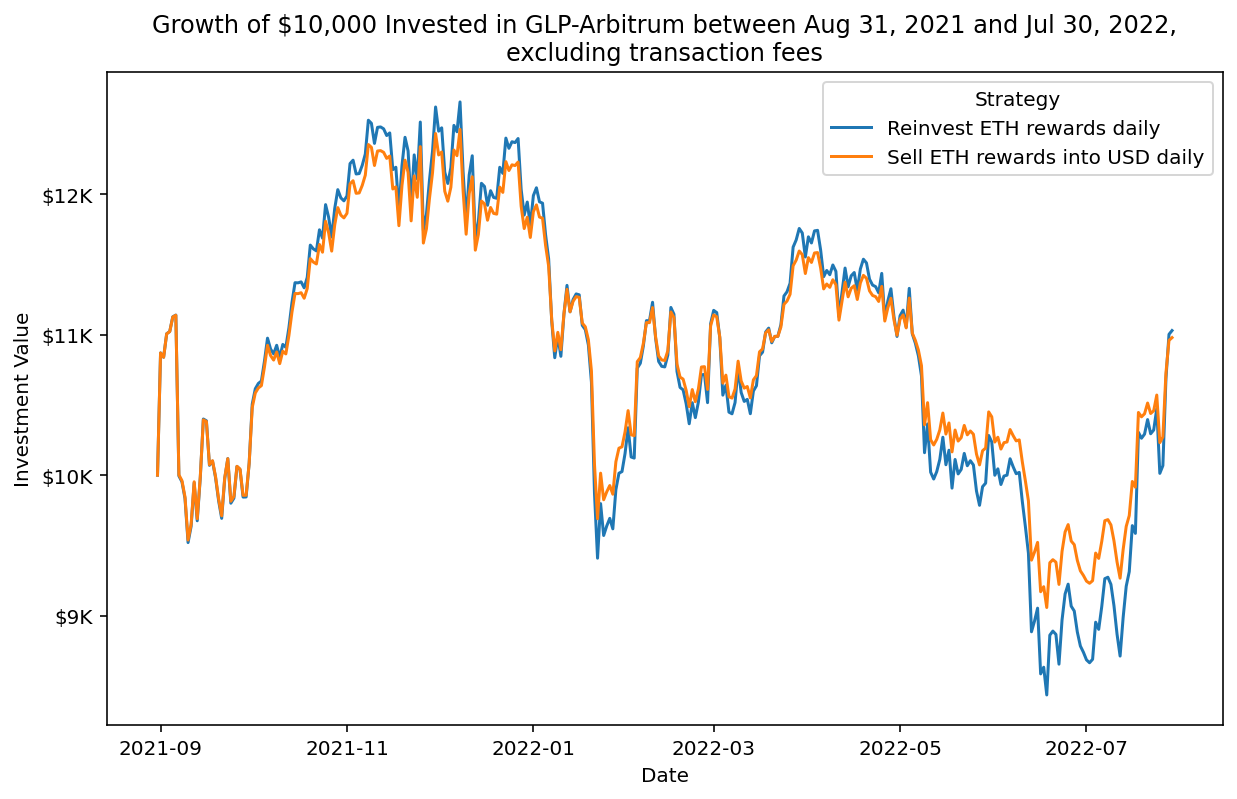

In [25]:
ax = sns.lineplot(data=df_long, x='Date', y='Investment Value', hue='Strategy')
ax.set(title="Growth of ${:,} Invested in GLP-{} between {} and {},\nexcluding transaction fees".format(init_capital, chain, start_date.strftime('%b %d, %Y'), last_day.strftime('%b %d, %Y'), reward_token))
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

fname = 'glp_compare_2strats_since_{}.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);